In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

Successfully pivoted the filtered dataset


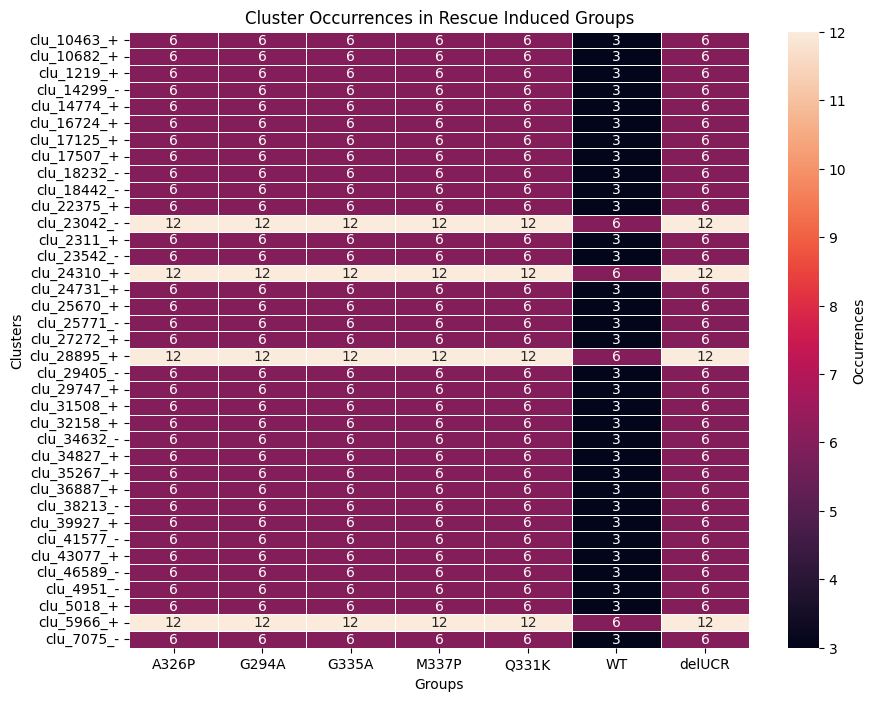

In [66]:
'''
HEATMAP ANALYSIS

This is an attempt to visualise which genotypes have higher or lower rescued groups, and which clusters are rescued.
'''

# read in filtered data
input_data = pd.read_csv('filtered_data.csv')

# pivot table to count occurrences of each cluster (event) in each group
try:    
    pivot_table = input_data.pivot_table(index='cluster', columns='genotype', aggfunc='size', fill_value=0)
    print('Successfully pivoted the filtered dataset')
except Exception as e:
    print(f"Error making heatmap: {e}")
    raise

# make heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, linewidth=.5, cbar_kws={'label': 'Occurrences'})
plt.title("Cluster Occurrences in Rescue Induced Groups")
plt.xlabel("Groups")
plt.ylabel("Clusters")

plt.show()

It seems some clusters have double the rescue expression rate (clu_5966_+, clu_28895_+, clu_23042_-) than all other clusters

Regarding the groups, the rescue expression rate is the same between groups, with the only anomaly being the WT group.

WT has a relatively high condensation propensity and full CR helix. 

In [65]:
'''
Principal Component Analysis on unfiltered cryptic dataset (which includes non-rescued junctions). 

This will reduce dimensionality, and also help highlight important any important features. 
'''

# Different dataset
input_data = pd.read_csv('unfiltered_cryptic_data.csv')

# Using same condensation scores
gene_mapping = {
    'G335A': 7,
    'WT': 6, 
    'G294A': 5,
    'Q331K': 4,
    'M337P': 3,
    'A326P': 2, 
    '316del346': 1 
}

input_data['Condensation Score'] = input_data['genotype'].map(gene_mapping)
print('successfully given genotypes a condensation score')

# Ignore incomplete rows again (removing rows with NaNs)
input_data = input_data.dropna()

# Split data into features and target
X = input_data[['Condensation Score', 'start', 'end', 'junction_count', 'cluster_total', 'psi']]
y = input_data['rescueExpression']

# Standardize the feature matrix - need normally distributed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
eigenValues = pca.explained_variance_ratio_

# save the principal components
pca_df = pd.DataFrame(data=principal_components)

print("Successfully carried out pca")

# calculate loadings matrix
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to align features with Principal Components
    columns=['PC1', 'PC2'],
    index=X.columns  # Original feature names are index
)

# finding most relevant features for each principal component
most_relevant_features = loadings.apply(lambda col: col.abs().nlargest(3).index, axis=0)
print(f"Most relevant features for each principal component:\n{most_relevant_features}")



successfully given genotypes a condensation score
Successfully carried out pca
Most relevant features for each principal component:
             PC1                 PC2
0            end                 psi
1          start      junction_count
2  cluster_total  Condensation Score


In this PCA, condensation score is displayed as a somewhat significant predictor due to its influence on Principal Component 2. cluster total, junction count, psi, start and end also remain important factors. 

The loadings matrix needs to be visualised to explore which of these features are the most important

<Figure size 800x500 with 0 Axes>

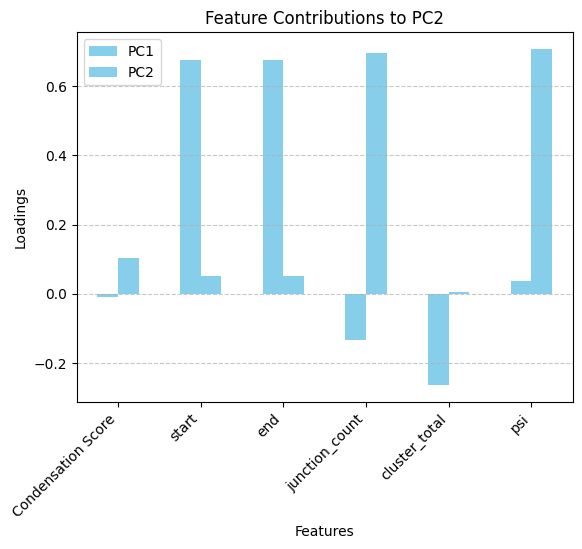

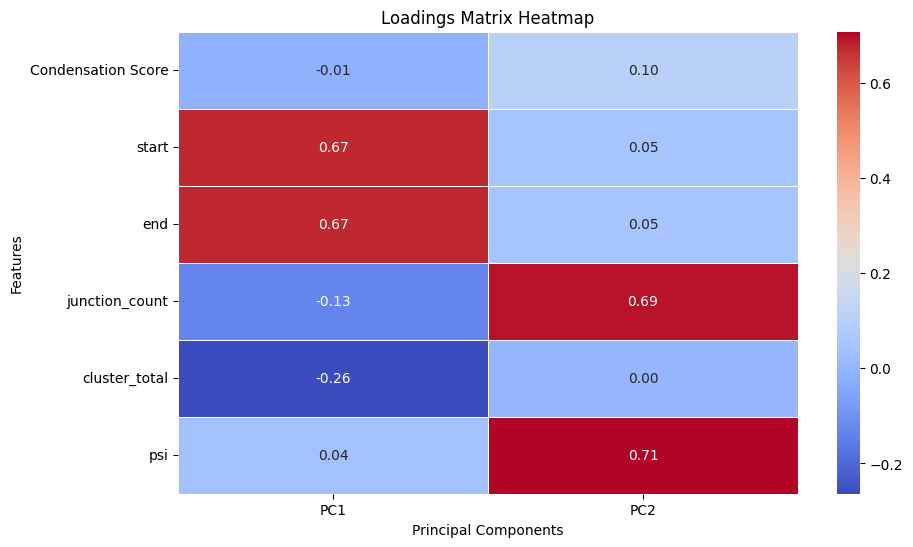

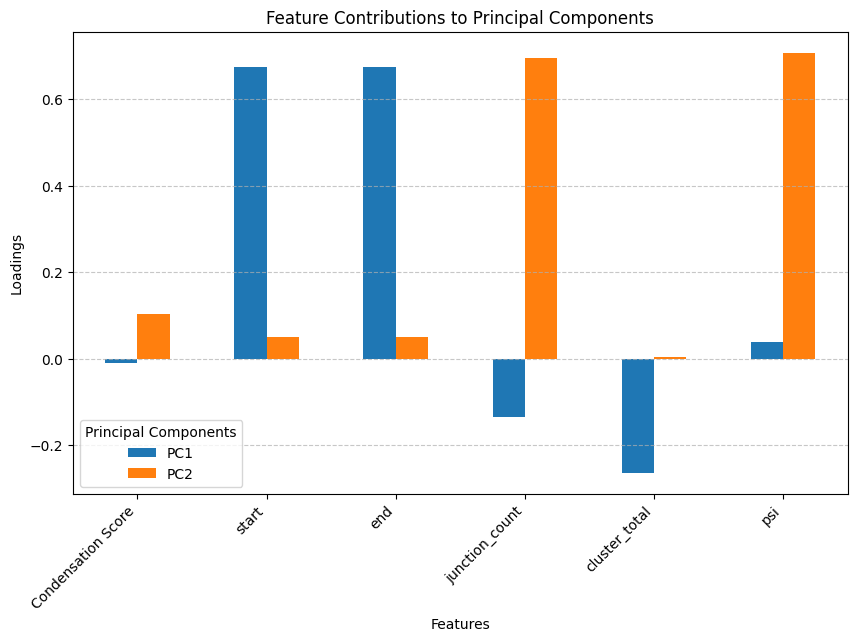

In [9]:
'''
Graph visualisation of the PCA results to see the influence of the original columns on the principal components.

'''

# plot bar plot
plt.figure(figsize=(8, 5))
loadings.plot(kind='bar', color='skyblue')
plt.title('Feature Contributions to PC2')
plt.ylabel('Loadings')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Loadings Matrix Heatmap')
plt.ylabel('Features')
plt.xlabel('Principal Components')
plt.show()

# Plot clustered bar chart
loadings.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Contributions to Principal Components')
plt.ylabel('Loadings')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Principal Components')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

COMMENTS: 

The bar plots indicate that start and end have large positive contributions to Principal Component 1. 
Furthermore, psi and junction count have large positive contributions to Principal Component 2. 

From both the heatmap and the bar plots, it can be seen that the arbitrary condensation score does not have a large contribution to either Principal Component. 

PCA has shown that the rudimentary condensation score I created has little importance on the likelihood of seeing a rescue expression (and hence cryptic splicing repression). The PCA instead indicates that parameters such as psi and junction_count are more important factors.

Successfully pivoted the filtered dataset


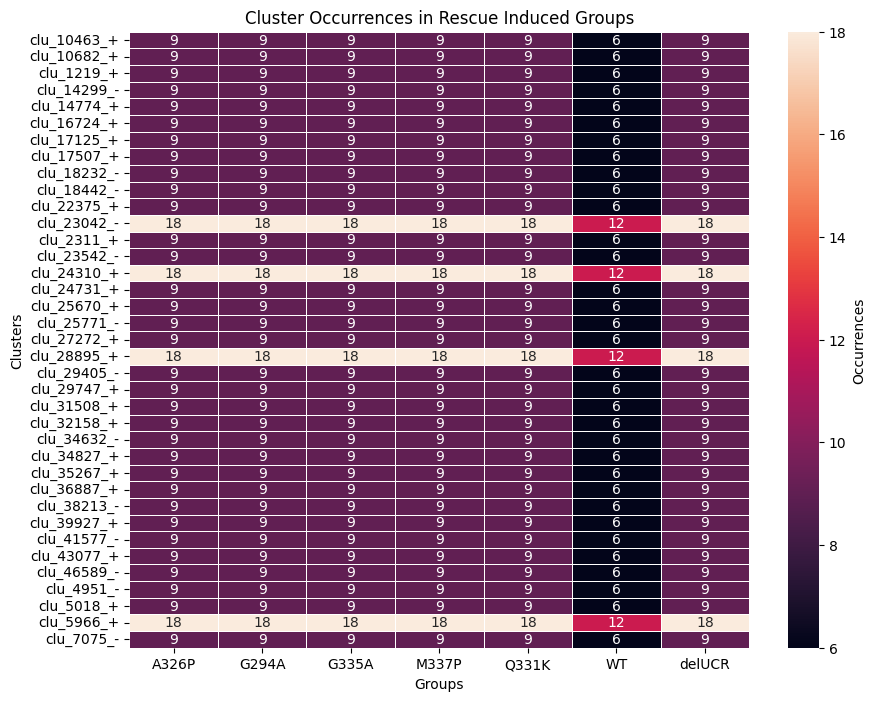

In [67]:
'''
HEATMAP ANALYSIS

This is an attempt to visualise any other trends or correlations in the non-rescue induced groups. 
'''

# read in filtered data
input_data = pd.read_csv('unfiltered_cryptic_data.csv')

# pivot table to count occurrences of each cluster (event) in each group
try:    
    pivot_table = input_data.pivot_table(index='cluster', columns='genotype', aggfunc='size', fill_value=0)
    print('Successfully pivoted the filtered dataset')
except Exception as e:
    print(f"Error making heatmap: {e}")
    raise

# make heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, linewidth=.5, cbar_kws={'label': 'Occurrences'})
plt.title("Cluster Occurrences in Rescue Induced Groups")
plt.xlabel("Groups")
plt.ylabel("Clusters")

plt.show()

COMMENTS: It seems no extra information can be found, WT group is still the only anomalous group.

In [19]:
'''
PCA on psi values (SECOND ATTEMPT)

USEFUL PARAMETERS FOR PCA:
junction_count - shows junction usage
cluster_total - 
psi - 
genotype - (one hot encoded)
n_significant_data - (only if correlates with psi or junction count), Could add value if junctions with low significant data are noisy or unreliable.

USEFUL FOR POST PCA INTERPRETATION:
start & end - maybe to map clusters back to location?
cluster - useful to see what each junction belongs to
rescueExpression - for final evaluation of cryptic splicing repression. 

DISCARDING:
chr - just chromosome?
junction_coords - no numerical or categorical information
gene_name - too high level? gene associated with junction, but I'm looking for genotype groups
strand
index_level 
sample_name
group
junct_cat - everything in dataset is cryptic 
TDP43_kd - this dataset only has junctions with knockdowns, as we are examining rescue expressions (cryptic respression)


Dataset:
unfiltered_cryptic_data = filtered junctions to all TDP_kd, all cryptics, but not all rescued.

'''

input_data = pd.read_csv('unfiltered_cryptic_data.csv')
input_data = input_data.dropna()
#input_data = input_data.drop(['n_significant_data','start','end','chr', 'junction_coords','gene_name','strand','__index_level_0__', 'sample_name', 'group','TDP43_kd'], axis=1)

# Pre-process data
input_data['rescue_encoded'] = input_data['rescueExpression'].map({'rescueInduced': 1, 'rescueNotInduced': 0})
# One hot encode genotypes
encoded_genotypes = pd.get_dummies(input_data['genotype'])
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(input_data[['genotype']])
encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

# Gather the useful data for PCA
processed_data = pd.concat([
    input_data[['junction_count', 'cluster_total', 'psi']],
    encoded_df
], axis=1)
processed_data = processed_data.dropna()

# Run PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(processed_data)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Save PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = input_data['cluster']
pca_df['rescueExpression'] = input_data['rescueExpression']

print('that worked')

that worked


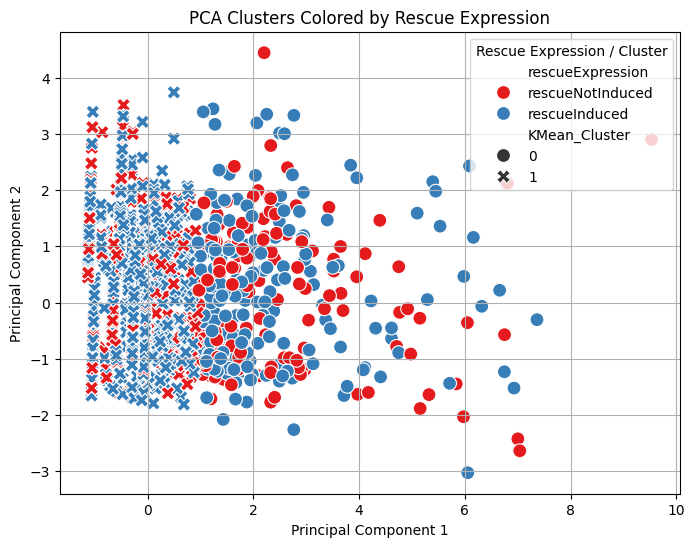

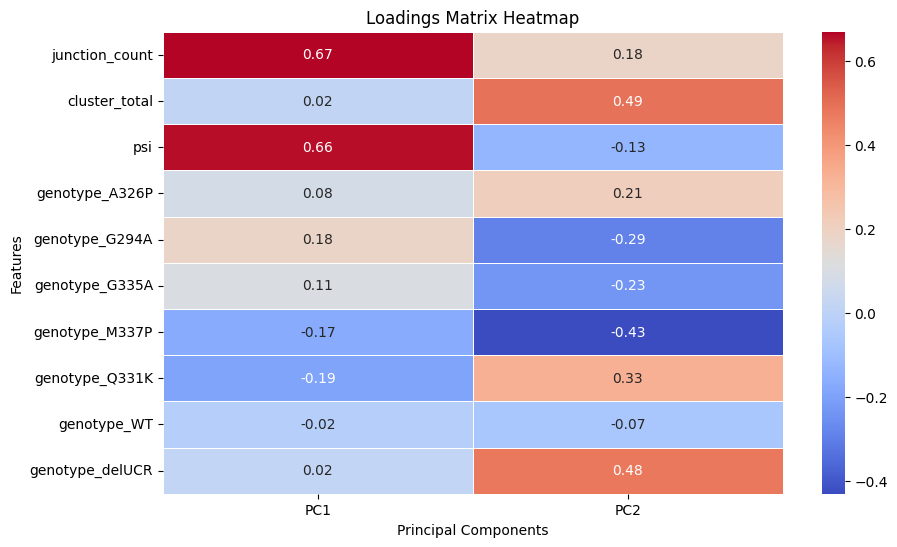

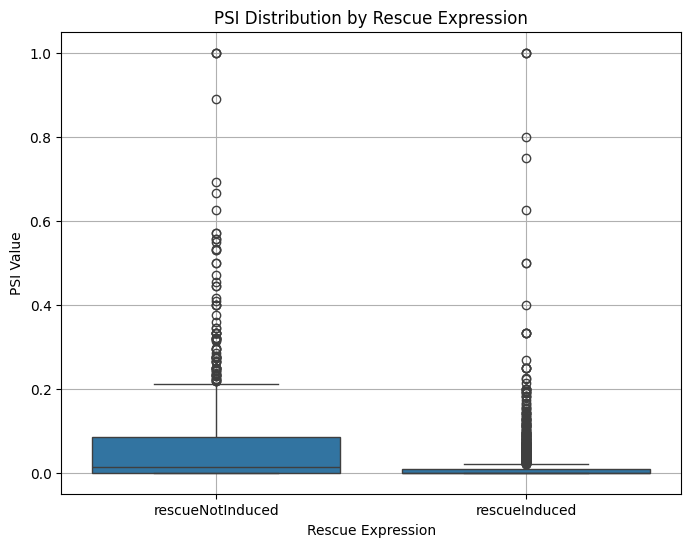

In [33]:
'''Post-PCA Analysis: Clustering Patterns'''


# Apply KMeans clustering to group junctions
kmeans = KMeans(n_clusters=2, random_state=42)
pca_df['KMean_Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])


# Visualize PCA clusters with rescueExpression
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='rescueExpression',
    style='KMean_Cluster',
    palette='Set1',
    s=100
)
plt.title('PCA Clusters Colored by Rescue Expression')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Rescue Expression / Cluster')
plt.grid()
plt.show()



# plot heatmap of psi contribution to the Principal Components 
# calculate loadings matrix
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to align features with Principal Components
    columns=['PC1', 'PC2'],
    index=processed_data.columns  # Original feature names are index
)

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Loadings Matrix Heatmap')
plt.ylabel('Features')
plt.xlabel('Principal Components')
plt.show()


# PSI vs. RescueExpression
plt.figure(figsize=(8, 6))
sns.boxplot(data=pca_df, x='rescueExpression', y=processed_data['psi'])
plt.title('PSI Distribution by Rescue Expression')
plt.xlabel('Rescue Expression')
plt.ylabel('PSI Value')
plt.grid()
plt.show()


COMMENTS: 

#### Cluster Plot: 
Clusters are relatively well separated, but colours are mixed within both clusters.
There is no clear separation of rescueExpression in either cluster. 
PC1 also captures more variance than PC2. 
The cluster separation indicates that the principal components have captured some meaningful patterns.
(More Principal components might be needed to capture better variance.)

#### Loadings Matrix Heatmap:
For PC1:
Psi has a high positive loading for PC1 (+0.66), meaning it strongly influences the variance captured in PC1. 
Junction count also has a high positive loading for PC1 (+0.67)

For PC2:
Cluster total and some genotypes have moderate contributions to PC2, but in general have weaker contributions. (Suggesting randomness in cryptic splicing repression) 

Psi and junction count are shown to be influential in the PCA, though their relationship with rescueExpression is not confirmed yet. 

#### PSI distribution by rescueExpression: 
Both groups have low psi values, 
The spread on rescueNotInduced is larger, but it seems psi along is not a strong predictor for rescueExpression. 

Number of rows in input data: (2442, 18)
Number of rows in encoded_df: (2442, 7)
Number of rows in the selected columns: (2442, 3)
Number of rows in processed_data: (2442, 10)
Features: ['junction_count', 'cluster_total', 'psi', 'A326P', 'G294A', 'G335A', 'M337P', 'Q331K', 'WT', 'delUCR']


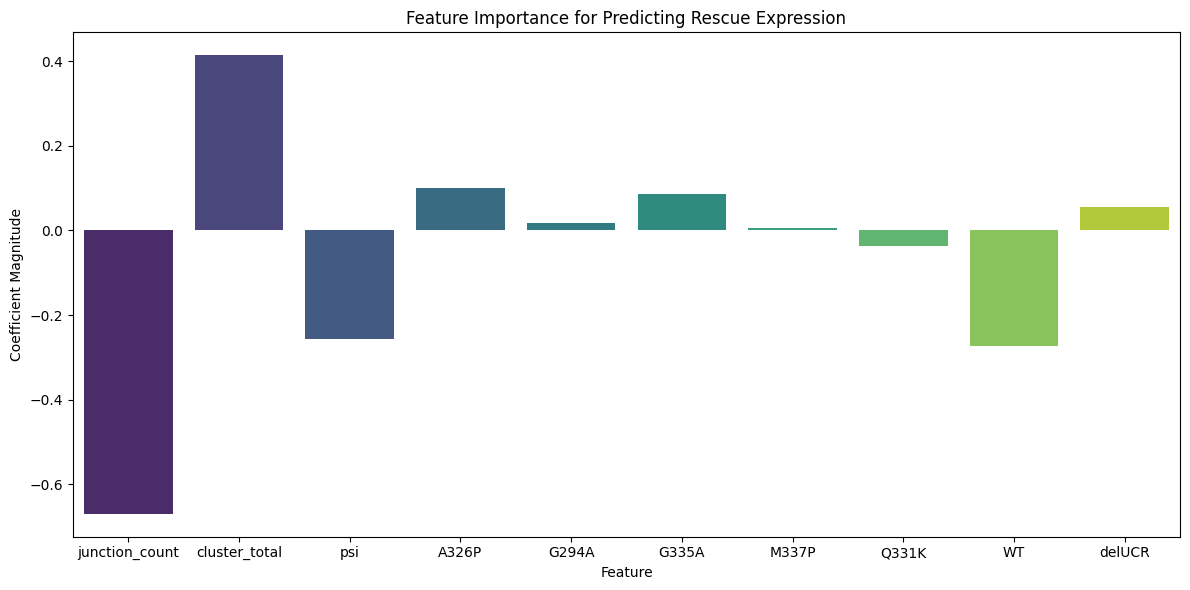

Model Accuracy: 0.67


In [64]:
'''
FURTHER STEPS:
Further analysis, the PCA did not seem too helpful in finding important features.

Logistic Regression for Feature Importance - supervised model to try and directly predict rescueExpression. 
'''
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 

input_data = pd.read_csv('unfiltered_cryptic_data.csv')
input_data = input_data.dropna()
print("Number of rows in input data:", input_data.shape)
#input_data = input_data.drop(['n_significant_data','start','end','chr', 'junction_coords','gene_name','strand','__index_level_0__', 'sample_name', 'group','TDP43_kd'], axis=1)

# Pre-process data
input_data['rescue_encoded'] = input_data['rescueExpression'].map({'rescueInduced': 1, 'rescueNotInduced': 0})
# One hot encode genotypes
encoded_genotypes = pd.get_dummies(input_data['genotype'])
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(input_data[['genotype']])
encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())
print("Number of rows in encoded_df:", encoded_df.shape)

print("Number of rows in the selected columns:", input_data[['junction_count', 'cluster_total', 'psi']].shape)
encoded_df = encoded_df.reset_index(drop=True)
input_data = input_data.reset_index(drop=True)

# Gather the useful data
processed_data = pd.concat([
    input_data[['junction_count', 'cluster_total', 'psi']],
    encoded_df
], axis=1, ignore_index=True)
print("Number of rows in processed_data:", processed_data.shape)

# Sort out all features to use in results analysis
features = ['junction_count', 'cluster_total', 'psi']
features += list(encoded_df.columns)
features = [feature.replace('genotype_', '') for feature in features]
print('Features:', features)

Y = input_data['rescue_encoded']
X = processed_data

# Standardise feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split and train regression model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

# Extract feature importance (coefficients)
feature_importance = model.coef_[0]
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df.to_csv('feature_importance.csv')

# Plot feature importance
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y='Importance', data=importance_df, hue='Feature', palette='viridis')
plt.title('Feature Importance for Predicting Rescue Expression')
plt.ylabel('Coefficient Magnitude')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

# Model accuracy evaluation (optional)
accuracy = model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')


#### COMMENTS: 

Junction count has the largest negative coefficient, indicating that high junctions counts have reduced cryptic splicing repression.

Cluster total has the highest positive coefficient, implying that larger clusters have increased cryptic splicing. 

psi also has a moderately large negative coefficient, indicating that lower psi increases cryptic splicing repression. 

Out of the genotype groups, WT has the most impact on predicting RescueExpression, which was seen in the earlier correlation heatmaps. WT had the greatest proportion of cryptic splicing repression. 

Conclusion:
Junction count and cluster total are shown to be the most influential predictors in this dataset. 

Model Accuracy is only moderately high (0.67)